<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/transfert_learningVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow

from google.colab import drive
from zipfile import ZipFile

from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomHeight, RandomWidth, RandomTranslation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## on importe le drive local duquel on copie les data dans l'environnement colab '/content' qui disparaitra a la fin de la session

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path_out = '/content/C19'                                                             #chemin dans l'env. colab ou on va copier les data
histo_equalize = False                                                                # sert a definir le type de donnees a utliser:  True: on recupere les images dont les histogrammes ont ete prealablement harmonises
                                                                                      #                                               False: on recupere les images originales

if histo_equalize:
  archive = '/content/drive/MyDrive/kaggle/covid19-histo_equal-dataset_for_ffd.zip'   # chemin de l'archive qui contient les donnees melangees au bon format pour ffd avec histogramme egalises
else:
  archive='/content/drive/MyDrive/kaggle/covid19--dataset_for_ffd.zip'                 # chemin de l'archive qui contient les donnees originales melangees au bon format pour ffd 
#on supprime le precedent s'il existe et on cree le repertoire pour accueillir les donnees
shutil.rmtree(path_out, ignore_errors=True)
os.mkdir(path_out)
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)

## Static data utiles pour le programme

In [5]:
data_types=['Test', 'Validation', 'Train']
cats = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
initial_size = (299,299)  #taille initiale des images
target_size = (224,224)   #redimensionnement des images a 224*244 qui est ce que demande VGG
training_bs = 32          #batch size pour entrainement/validation
image_augmentation = False #couches d'augmentation d'image dans le modele
rotation_factor = 0.1
zoom_factor = 0.1
contrast_factor = 0.1
width_factor = 0.1
height_factor = 0.1
flip = 'horizontal_and_vertical'

# parametres du premier modele simple
dropout_rate=0.2         #taux de drop_out apres chaque couche dense
n_dense=2                #nb de couche dense apres la convolution
n_units=256              #nb de neurones pour chaque couche dense

#chemin ou on sauve les resultats
if histo_equalize:
  eq = 'HE'
else:
  eq = ''
if image_augmentation:
  ia = 'IA'
else:
  ia = ''
name = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/VGG16'+str(n_dense)+str(n_units)+str(dropout_rate)+eq+ia
name_ft = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/VGG16FineTune'+str(n_dense)+str(n_units)+str(dropout_rate)+eq+ia

#chemin ou on sauve les modeles
path_saved_models = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16'
path_saved_models_ft = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16FineTune'

## Verification des repertoires et des images

In [6]:
n_data_by_type = []
for data_type in data_types:
  n = 0
  print(data_type)
  for cat in cats:    
    print('la categorie {} possede {} images'.format(cat,len(os.listdir(os.path.join(path_out, data_type, cat)))))
    n += len(os.listdir(os.path.join(path_out, data_type, cat)))
  print('le nb total d\'images dans {} est {}'.format(data_type, n))
# on calcule le nb d'images par classes sur l'ensemble d'entrainement et on pondere chaque classe par 1/nb d'elements dans la classe pour equilibrer le dataset
n_images_train = 0
class_weights = {}
for i, cat in enumerate(cats):
  n_train_cat = len(os.listdir(os.path.join(path_out, 'Train', cat)))
  n_images_train += n_train_cat
  class_weights[i] = 1 / n_train_cat
for i in range(len(cats)):
  class_weights[i] = n_train_cat * class_weights[i]
print("class_weights utilisera les poids suivants:", class_weights)

Test
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Test est 3172
Validation
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Validation est 3172
Train
la categorie COVID possede 2531 images
la categorie Lung_Opacity possede 4209 images
la categorie Normal possede 7135 images
la categorie Viral Pneumonia possede 942 images
le nb total d'images dans Train est 14817
class_weights utilisera les poids suivants: {0: 0.3721849071513236, 1: 0.22380612972202424, 2: 0.13202522775052558, 3: 1.0}


## creation des data_generator

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)                                  
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(directory=os.path.join(path_out,'Train'),
                                                    #color_mode='grayscale',
                                                    color_mode='rgb',
                                                    class_mode='sparse', 
                                                    target_size=target_size,
                                                    batch_size=training_bs,
                                                    )

validation_generator = val_datagen.flow_from_directory(directory=os.path.join(path_out,'Validation'),
                                                         #color_mode='grayscale',
                                                       color_mode='rgb',
                                                         class_mode='sparse', 
                                                         target_size=target_size,
                                                         batch_size=training_bs,
                                                         )

test_generator = test_datagen.flow_from_directory(directory=os.path.join(path_out,'Test'),
                                                  #color_mode='grayscale',
                                                  color_mode='rgb',
                                                  class_mode='sparse', 
                                                  target_size=target_size,
                                                  shuffle = False, 
                                                  batch_size=1)


Found 14817 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.


## on peut verifier la repartition des classes dans chacun des groupes

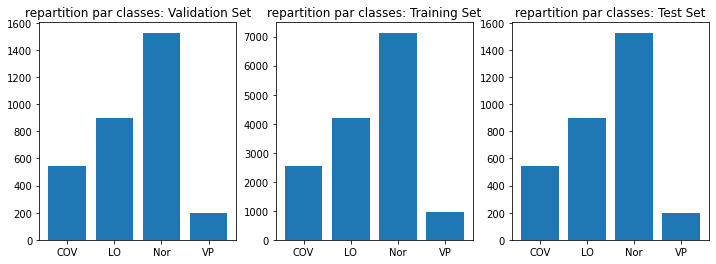

In [ ]:
classes_val, n_classes_val = np.unique(validation_generator.labels, return_counts=True)
classes_train, n_classes_train = np.unique(train_generator.labels, return_counts=True)
classes_test, n_classes_test = np.unique(test_generator.labels, return_counts=True)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('repartition par classes: Validation Set')
plt.bar(classes_val, n_classes_val)
plt.xticks(classes_val, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(132)
plt.title('repartition par classes: Training Set')
plt.bar(classes_train, n_classes_train)
plt.xticks(classes_train, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(133)
plt.title('repartition par classes: Test Set')
plt.bar(classes_test, n_classes_test)
plt.xticks(classes_test, ['COV', 'LO', 'Nor', 'VP'])

if False:
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/covid/modeles/repartition_data.png')

plt.show()

## ATTENTION: pas encore utilise, a modifier pour prendre en compte les images en RGB; creation des couches d'augmentation d'images
On le fait dans le modele directement, cela est plus rapide avec le GPU

ValueError: ignored

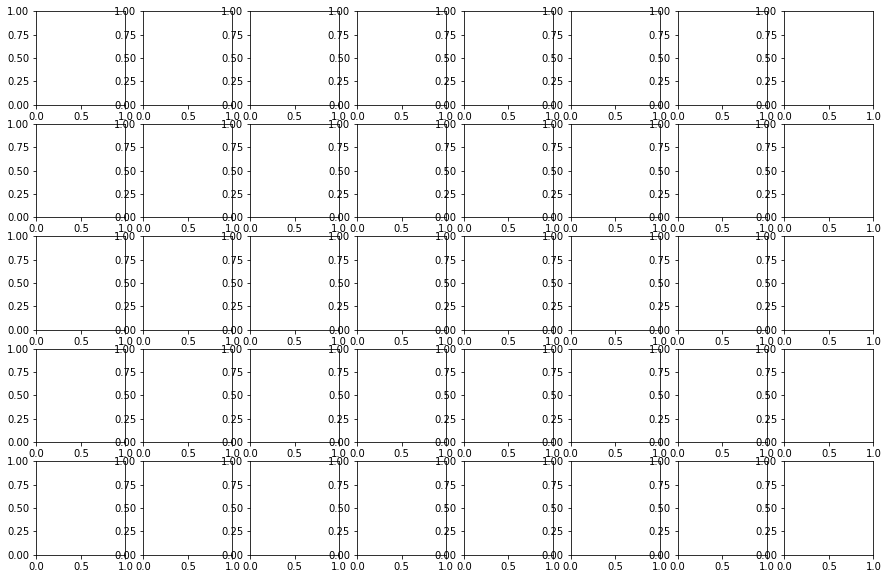

In [ ]:
#ne fonctionne pas tel quel
#images a redimensionner pour prendre en compte RGB
data_augmentation = Sequential(
    [
        RandomFlip(flip),
        RandomRotation(rotation_factor),
        #RandomRotation(0.1),
        #RandomZoom(0.8),
        RandomZoom(zoom_factor),
        #RandomContrast(contrast_factor),
        #RandomContrast(0.1),
        #RandomHeight(0.2), 
        #RandomWidth(0.2),
        RandomTranslation(height_factor,width_factor),
        #RandomTranslation(0.2,0.2),
    ]
)
#data_augmentation.build(input_shape=(target_size[0], target_size[1], 1))

nb_img = 5
nb_transformation = 7
fig, axs = plt.subplots(nb_img, nb_transformation+1, figsize=(15,10))

train_generator.reset()
for row in range(nb_img):
  images, labels = train_generator.next()
  #indice = np.random.randint(images.shape[0])
  img = images[0].reshape(target_size)
  axs[row, 0].imshow((1.0+img)/2.0)
  axs[row, 0].axis('off')
  axs[row, 0].set_title('originale  '+str(int(labels[0])))
  for col in range(1,nb_transformation+1):
    augmented_images = data_augmentation(images)
    img = augmented_images[0].numpy().astype("uint8")
    axs[row, col].imshow(img.reshape(img.shape[0],img.shape[1]), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('augmented')

train_generator.reset()

# !!!! ne pas utiliser randomcontrast qui va generer des taches blanches et noires


#Creation du modele

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
  layer.trainable = False
  

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
def build_model(dropout_rate, n_dense, n_units, loss, summary):
    #if image_augmentation:
    #  mod.add(data_augmentation)
    mod = Sequential()
    mod.add(base_model)
    mod.add(GlobalAveragePooling2D())
    for i in range(n_dense):
      mod.add(Dense(units=n_units, activation='relu'))
      mod.add(Dropout(rate=dropout_rate))
    mod.add(Dense(units = 4, activation='softmax'))
      
    mod.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    if summary:
      mod.summary()

    return(mod)

model = build_model(dropout_rate=dropout_rate, n_dense=n_dense, n_units=n_units, loss='sparse_categorical_crossentropy', summary=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

## entrainement du modele

In [ ]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0.001,
                   patience=4,
                   mode="min",
                   restore_best_weights=True, 
                   verbose=1)

red_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5, 
                           patience=2, 
                           min_delta = 0.01, 
                           #cooldown=3, 
                           verbose=1)

checkpoint = ModelCheckpoint(filepath=path_saved_models, save_best_only=True, verbose=1)

training_history_model = model.fit_generator(train_generator, 
                                             epochs=20,
                                             steps_per_epoch = train_generator.samples//train_generator.batch_size,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.samples//validation_generator.batch_size,
                                             class_weight=class_weights,
                                             callbacks=[es, red_lr, checkpoint]
                                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
463/463 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.7453
Epoch 1: val_loss improved from inf to 0.41892, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16/assets
463/463 [==============================] - 175s 349ms/step - loss: 0.1536 - accuracy: 0.7453 - val_loss: 0.4189 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/20
463/463 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.8350
Epoch 2: val_loss improved from 0.41892 to 0.36226, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16/assets
463/463 [==============================] - 161s 347ms/step - loss: 0.0887 - accuracy: 0.8350 - val_loss: 0.3623 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 3/

In [ ]:
   def show_training_model(hist, save=False, mod='mod'):
    fig = plt.figure(figsize=(10,5))
    epochs = len(hist.history['accuracy'])
    ax1 = fig.add_subplot(121)
    ax1.plot(np.arange(1,epochs+1,1), hist.history['accuracy'], 'blue', label='training')
    ax1.plot(np.arange(1,epochs+1,1), hist.history['val_accuracy'], 'r', label='validation')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.legend()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(1,epochs+1,1), hist.history['loss'], 'blue', label='training')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax3 = ax2.twinx()
    ax3.plot(np.arange(1,epochs+1,1), hist.history['val_loss'], 'r', label='validation')
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('Loss')
    ax3.legend(loc='upper left')
    if save:
        plt.savefig(mod+'.png')

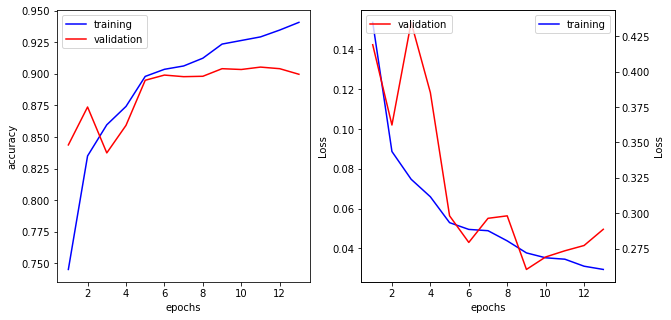

In [ ]:

show_training_model(training_history_model, save=True, mod=name)

#Avant d'affiner les parametres, on regarde la performance sur test et on enregistre les resultats

In [ ]:
def perf_model_on_test(mod, test_gen):
#  print("performance du modele sur ensemble de test:", mod.evaluate(test_generator)[1])
  test_gen.reset()
  y_pred = mod.predict(x=test_gen, 
                         steps=test_gen.samples//test_gen.batch_size, 
                         verbose=1)
  y_pred_class = np.argmax(y_pred, axis=1)
  y_test_class = test_gen.labels
  report = classification_report(y_test_class, y_pred_class)
  cm = pd.crosstab(y_test_class, y_pred_class, rownames=['realite'], colnames=['prediction'])

  return report, cm

In [ ]:
cr, cm = perf_model_on_test(model, test_generator)
print(cr)
print(cm)

3172/3172 [==============================] - 93s 29ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       542
           1       0.90      0.86      0.88       901
           2       0.91      0.95      0.93      1528
           3       0.96      0.97      0.96       201

    accuracy                           0.92      3172
   macro avg       0.93      0.93      0.93      3172
weighted avg       0.92      0.92      0.92      3172

prediction    0    1     2    3
realite                        
0           506   16    18    2
1            12  775   114    0
2            10   65  1446    7
3             2    1     3  195


In [ ]:
def save_config_and_model_results(dropout_rate, n_dense, n_units, train_hist, class_report, confusion_matrix, name):
  res = {}
  res['date'] = str(datetime.datetime.today()).split()[0]
  res['target_size'] = target_size   
  res['Nmax'] = 11200
  res['histo_equalize'] = histo_equalize
  res['image_augmentation'] = image_augmentation
  res['rotation_factor'] = rotation_factor
  res['zoom_factor'] = zoom_factor
  res['contrast_factor'] = contrast_factor
  res['flip'] = flip
  res['val_split'] = 15
  res['test_split'] = 15
  res['hist'] = train_hist.history
  res['cr'] = class_report
  res['confusion_matrix'] = confusion_matrix
  res['drop_out'] = dropout_rate
  res['n_dense'] = n_dense
  res['n_units'] = n_units
  np.save(name, res)

In [ ]:
save_config_and_model_results(dropout_rate, n_dense, n_units,training_history_model, cr, cm, name+'.npy')

# on va tester que l'enregistrement du modele s'est bien deroule

In [ ]:
#on va tester que l'enregistrement du modele s'est bien deroule
cr, cm = perf_model_on_test(model, test_generator)
print(cr)
print(cm)

In [ ]:
#reproduisons les memes resultats avec le modele issu du point de sauvegarde
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/MobileNet')

In [ ]:
cr2, cm2 = perf_model_on_test(new_model, test_generator)
print(cr2)
print(cm2)

# On va affiner les parametres du modele

In [ ]:
# on va affiner les parametres
for layer in base_model.layers:
  layer.trainable = True

#on baisse lr a 0.00001
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

checkpoint2 = ModelCheckpoint(filepath=path_saved_models_ft, save_best_only=True, verbose=1)

training_history_model_finetune = model.fit_generator(train_generator, 
                                             epochs=50,
                                             steps_per_epoch = train_generator.samples//train_generator.batch_size,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.samples//validation_generator.batch_size,
                                             class_weight=class_weights,
                                             callbacks=[es, red_lr, checkpoint2]
                                             )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9096
Epoch 1: val_loss improved from inf to 1.15664, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16FineTune
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16FineTune/assets
463/463 [==============================] - 422s 898ms/step - loss: 0.0480 - accuracy: 0.9096 - val_loss: 1.1566 - val_accuracy: 0.7105 - lr: 1.0000e-05
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9277
Epoch 2: val_loss improved from 1.15664 to 0.21098, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16FineTune
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/VGG16FineTune/assets
463/463 [==============================] - 412s 889ms/step - loss: 0.0385 - accuracy: 0.9277 - val_loss: 0.2110 - val_ac

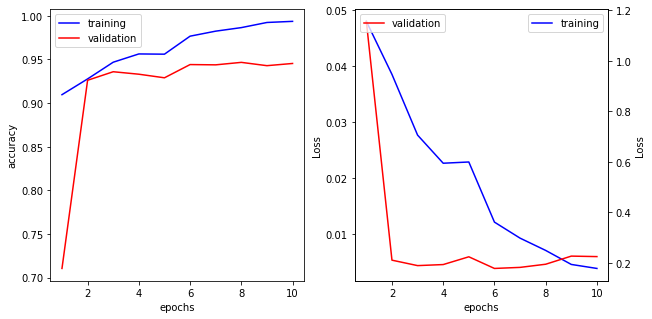

In [ ]:
show_training_model(training_history_model_finetune, save=True, mod=name_ft)

## Rergardons la performance du modele sur l'ensemble de test

In [ ]:
cr_finetune, cm_finetune = perf_model_on_test(model, test_generator)
print(cr_finetune)
print(cm_finetune)

3172/3172 [==============================] - 95s 30ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       542
           1       0.95      0.89      0.92       901
           2       0.93      0.97      0.95      1528
           3       0.98      0.97      0.97       201

    accuracy                           0.95      3172
   macro avg       0.96      0.95      0.96      3172
weighted avg       0.95      0.95      0.95      3172

prediction    0    1     2    3
realite                        
0           527    6     7    2
1             3  804    94    0
2             4   33  1489    2
3             0    0     6  195


In [ ]:
save_config_and_model_results(dropout_rate, n_dense, n_units,training_history_model_finetune, cr_finetune, cm_finetune, name_ft+'.npy')

In [ ]:
 #verification que l'enregistrement des resultats s'est bien deroule

new_dict = np.load(name_ft+'.npy', allow_pickle='TRUE').item()

cr1 = new_dict['cr']
cm1 = new_dict['confusion_matrix']
print(cr1)
print(cm1)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       542
           1       0.95      0.89      0.92       901
           2       0.93      0.97      0.95      1528
           3       0.98      0.97      0.97       201

    accuracy                           0.95      3172
   macro avg       0.96      0.95      0.96      3172
weighted avg       0.95      0.95      0.95      3172

prediction    0    1     2    3
realite                        
0           527    6     7    2
1             3  804    94    0
2             4   33  1489    2
3             0    0     6  195


In [ ]:
new_dict['hist']['accuracy']

[0.9096381664276123,
 0.9276970028877258,
 0.9468380212783813,
 0.956307053565979,
 0.9560365080833435,
 0.9766655564308167,
 0.9824146032333374,
 0.9864727854728699,
 0.9923571348190308,
 0.9936422109603882]

#rechargeons le modele et regardons quelques images qui n'ont pas ete bien classees

In [8]:
#rechargeons le modele
new_model = load_model(path_saved_models_ft)

In [9]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

(224, 224, 3) -123.68 151.061
(224, 224, 3) 0.0 1.0


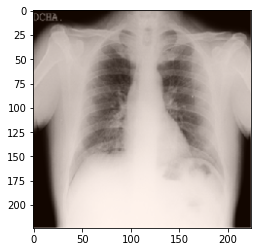

In [13]:
image, label = test_generator.next()
img = image[0]
print(img.shape, img.min(), img.max())
img = (img - img.min())/(img.max()-img.min())
print(img.shape, img.min(), img.max())
plt.imshow(img)

In [14]:
y_pred = new_model.predict(x=test_generator, 
                         steps=test_generator.samples//test_generator.batch_size, 
                         verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = test_generator.labels
report = classification_report(y_test_class, y_pred_class)
cm = pd.crosstab(y_test_class, y_pred_class, rownames=['realite'], colnames=['prediction'])

  32/3172 [..............................] - ETA: 29:03

KeyboardInterrupt: ignored

In [ ]:
print(report)
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       542
           1       0.95      0.89      0.92       901
           2       0.93      0.97      0.95      1528
           3       0.98      0.97      0.97       201

    accuracy                           0.95      3172
   macro avg       0.96      0.95      0.96      3172
weighted avg       0.95      0.95      0.95      3172

prediction    0    1     2    3
realite                        
0           527    6     7    2
1             3  804    94    0
2             4   33  1489    2
3             0    0     6  195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-123.68 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

157 [20, 36, 81, 119, 147, 161, 187, 212, 260, 298, 307, 338, 429, 447, 527, 565, 578, 580, 592, 598, 616, 640, 659, 665, 693, 696, 703, 713, 722, 729, 731, 737, 759, 780, 808, 810, 812, 815, 822, 823, 824, 826, 845, 849, 898, 911, 932, 944, 945, 947, 969, 985, 990, 1017, 1021, 1024, 1030, 1031, 1053, 1054, 1059, 1060, 1064, 1066, 1067, 1071, 1078, 1082, 1088, 1089, 1094, 1095, 1098, 1103, 1115, 1117, 1118, 1126, 1128, 1131, 1136, 1142, 1150, 1153, 1157, 1163, 1173, 1179, 1187, 1188, 1190, 1198, 1216, 1220, 1246, 1249, 1267, 1282, 1283, 1304, 1306, 1342, 1351, 1355, 1384, 1387, 1399, 1415, 1416, 1429, 1438, 1439, 1538, 1589, 1634, 1655, 1716, 1732, 1875, 1909, 1947, 1960, 1987, 1990, 1995, 2061, 2141, 2152, 2194, 2203, 2218, 2226, 2269, 2403, 2431, 2435, 2437, 2501, 2598, 2605, 2610, 2655, 2666, 2670, 2781, 2782, 2850, 2861, 2890, 2930, 2964, 2972, 3068, 3069, 3098, 3102, 3171]


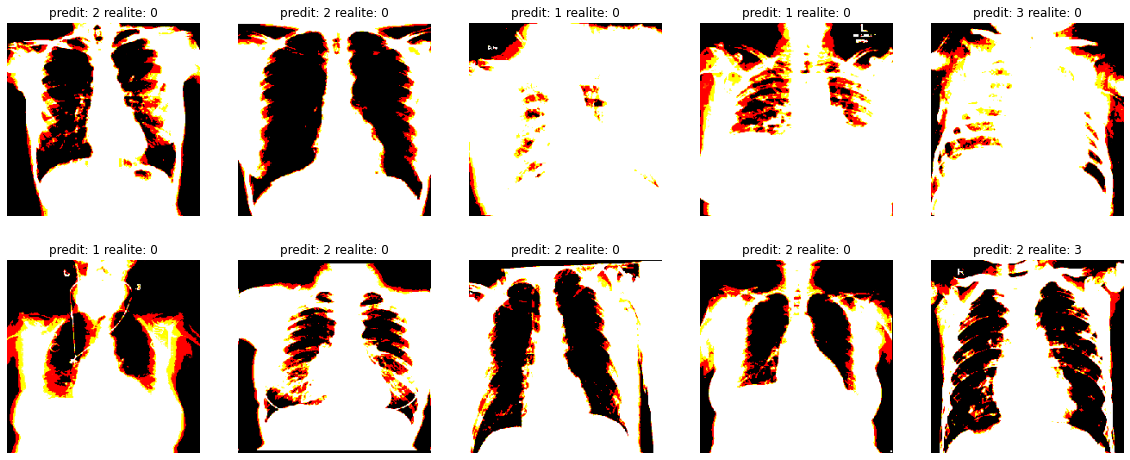

In [ ]:
#sortons les images mal classees et regardons les 10 premieres

n_affiche=10
fig = plt.figure(figsize=(20,8))
cpteur = 0
liste_error = []
test_generator.reset()
for i in range(len(y_pred_class)):
  image, label = test_generator.next()
  if y_pred_class[i] != y_test_class[i]:
    plt.subplot(2,n_affiche//2,min(cpteur+1,n_affiche))
    img = image[0]
    img = (img - img.min())/(img.max()-img.min())
    plt.imshow(img) #en sortie de preprocessing, les images sont centrees autour de 0 simplement; on les ramene entre 0 et 1 pour un affichage correct
    plt.title("predit: {} realite: {}".format(y_pred_class[i], int(label[0])))
    plt.axis("off");
    #print(img.shape, img.max(), label, y_test_class[i], y_pred_class[i])
    liste_error.append(i)
    #print('le modele a prevu {} a la place de {}'.format(y_pred_class[i], y_test_class[i]))
    cpteur += 1
print(cpteur, liste_error)
